<h1><center>Tarea 3 - Clasificación de Sentimientos en Tweets

<center>Kin Nevárez<center>
    
<center>2 de junio 2022<center>

<center>Facultad de Ciencias Físico Matemáticas<center>

<center>Maestría en Ciencia de Datos<center>

___

# 1. Resumen

El código a continuación es una ejemplificación de diferentes algoritmos de aprendizaje supervisado que se pueden utilizar para la clasificación de tres tipos de sentimiento en comentarios de redes sociales: Positivo, Negativo y Neutral.

Cabe destacar que el código también presenta código de pre-procesamiento de texto, sin embargo, no es el objetivo principal de la asignación.

La base de datos utilizada tiene el nombre "First GOP Debate Twitter Sentiment" y fue obtenida del repositorio de Kaggle, en la siguiente liga: https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment?resource=download

Esta base de datos contiene más de 10,000 tweets sobre el primer debate presidencial de 2016 celebrado en Ohio.

______________

# 2. Establecimiento del espacio de trabajo

Se importan las librerías necesarias para las funciones utilizadas.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Para trabajar con data.frames
import numpy as np
import pandas as pd
import time

#Para limpieza de texto
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
#Para análisis de sentimiento con vader
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.9 MB/s 


In [4]:
#Preparación y evaluación de los modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
#Algoritmos de clasificación
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [6]:
#visualización de datos
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.io as pio
pio.renderers.default = "colab"
import seaborn as sb
import matplotlib.pyplot as plt

___

# 3. Acceso a los datos

Se lee el csv descargado:

In [7]:
import os
os.chdir('/content/drive/MyDrive/MAESTRÍA/TETRAMESTRE 4/PROCESAMIENTO Y CLASIFICACIÓN/TAREA 3')

In [8]:
tweets=pd.read_csv('Sentiment.csv',encoding='utf-8')
tweets.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


___

# 4. Pre - procesamiento

### 4.1 Limpieza

Al estar trabajando con tweets, es necesario hacer limpieza de datos muy específica, la cual contempla los siguientes pasos:

In [9]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    # Eliminación de palabras que contienen @
    nuevo_texto = [token for token in nuevo_texto if '@' not in token]
    # Unir de nuevo las palabras
    texto_final = ' '.join([str(item) for item in nuevo_texto])
    return(texto_final)

In [10]:
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto crudo:')
print(tweets['text'][200])
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio:')
print(limpiar_tokenizar(texto=tweets['text'][200]))

-----------------------------------------------------------------------------------------------------------------
Texto crudo:
RT @Playing_Dad: Settling in for the #GOPDebate http://t.co/W6W3e5NBOa
-----------------------------------------------------------------------------------------------------------------
Texto limpio:
rt dad settling in for the gopdebate


In [11]:
tweets['clean_text'] = tweets['text'].apply(lambda x: limpiar_tokenizar(x))
tweets[['name','text', 'clean_text']].head().head()

,name,text,clean_text
0,I_Am_Kenzi,RT @NancyLeeGrahn: How did everyone feel about...,rt how did everyone feel about the climate cha...
1,PeacefulQuest,RT @ScottWalker: Didn't catch the full #GOPdeb...,rt didn catch the full gopdebate last night he...
2,PussssyCroook,RT @TJMShow: No mention of Tamir Rice and the ...,rt no mention of tamir rice and the gopdebate ...
3,MattFromTexas31,RT @RobGeorge: That Carly Fiorina is trending ...,rt that carly fiorina is trending hours after ...
4,sharonDay5,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,rt gopdebate delivered the highest ratings in ...


Se puede observar que fueron eliminados los caracteres especiales, con excepción del "@", pues éste siempre se usa para etiquetar a otro usuario y los nombres de usuario no son más que ruido,por lo que se eliminan todas las palabras que contengan un "@".

### 4.2 Stop Words

Se eliminan las palabras más frecuentes en el idioma inglés. Éstas no proporcionan información relevante en los textos analizados.

A diferencia de otras ocasiones, se usa módulo gensim pues contiene un listado de stopwords más completo que el comúnmente utilizado en nltk. Para más información sobre este módulo,visitar: https://stackabuse.com/removing-stop-words-from-strings-in-python/.

Aunado a esto, se agregan palabras que en el contexto actual no son relevantes, como "rt" que indica un retweet y está presente en muchos textos, asícomo "gobdebate" que está incluido como etiqueta #GOBDebate.

In [12]:
my_sw = STOPWORDS.union(set(['rt','gobdebate','gopdebate','gopdebates']))
final_sw = my_sw.difference({'not'})

In [13]:
def remove_sw(text): 
    #Tokenización
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in final_sw]
    # Unir de nuevo las palabras
    texto_final = ' '.join([str(item) for item in tokens_without_sw])
    return(texto_final)

In [14]:
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio con stopwords:')
print(tweets['clean_text'][250])
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio sin stopwords:')
print(remove_sw(tweets['clean_text'][250]))

-----------------------------------------------------------------------------------------------------------------
Texto limpio con stopwords:
rt olivia pope would not vote for any of these guys gopdebate
-----------------------------------------------------------------------------------------------------------------
Texto limpio sin stopwords:
olivia pope not vote guys


In [15]:
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: remove_sw(x))

In [16]:
tweets[['text','clean_text']].head(10)

,text,clean_text
0,RT @NancyLeeGrahn: How did everyone feel about...,feel climate change question night exactly
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,catch night scott best lines seconds walker
2,RT @TJMShow: No mention of Tamir Rice and the ...,mention tamir rice held cleveland wow
3,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hours debate men comple...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,delivered highest ratings history presidential...
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",tx day rescind illegal executive action taken ...
6,RT @warriorwoman91: I liked her and was happy ...,liked happy heard going moderator not anymore
7,Going on #MSNBC Live with @ThomasARoberts arou...,going msnbc live pm et
8,Deer in the headlights RT @lizzwinstead: Ben C...,deer headlights ben carson brain surgeon perfo...
9,RT @NancyOsborne180: Last night's debate prove...,night debate proved batsask tbats


### 4.3 Origen de palabras y lematización

Se hace uso de un diccionario que contiene el tipo de palabra utilizada en la oración: adjetivo, verbo, sustantivo y adverbio para poder obtener la palabra raíz de ésta, por medio de la lematización.

In [17]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

In [18]:
def pos_tag_text(text):
    tags = pos_tag(word_tokenize(text))
    tagged = []
    for word, tag in tags:
        tagged.append(tuple([word, pos_dict.get(tag[0])]))
    return tagged

In [19]:
print('Texto limpio sin stopwords, sin tag:')
print(tweets['clean_text'][0])
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio sin stopwords, con tag:')
print(pos_tag_text(tweets['clean_text'][0]))

Texto limpio sin stopwords, sin tag:
feel climate change question night exactly
-----------------------------------------------------------------------------------------------------------------
Texto limpio sin stopwords, con tag:
[('feel', 'n'), ('climate', 'n'), ('change', 'n'), ('question', 'n'), ('night', 'n'), ('exactly', 'r')]


In [20]:
tweets['pos_tagged'] = tweets['clean_text'].apply(pos_tag_text)

In [21]:
tweets[['text','clean_text','pos_tagged']].head(10)

,text,clean_text,pos_tagged
0,RT @NancyLeeGrahn: How did everyone feel about...,feel climate change question night exactly,"[(feel, n), (climate, n), (change, n), (questi..."
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,catch night scott best lines seconds walker,"[(catch, n), (night, n), (scott, n), (best, r)..."
2,RT @TJMShow: No mention of Tamir Rice and the ...,mention tamir rice held cleveland wow,"[(mention, n), (tamir, n), (rice, n), (held, v..."
3,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hours debate men comple...,"[(carly, r), (fiorina, a), (trending, n), (hou..."
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,delivered highest ratings history presidential...,"[(delivered, v), (highest, a), (ratings, n), (..."
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",tx day rescind illegal executive action taken ...,"[(tx, a), (day, n), (rescind, v), (illegal, a)..."
6,RT @warriorwoman91: I liked her and was happy ...,liked happy heard going moderator not anymore,"[(liked, v), (happy, a), (heard, n), (going, v..."
7,Going on #MSNBC Live with @ThomasARoberts arou...,going msnbc live pm et,"[(going, v), (msnbc, a), (live, a), (pm, n), (..."
8,Deer in the headlights RT @lizzwinstead: Ben C...,deer headlights ben carson brain surgeon perfo...,"[(deer, n), (headlights, n), (ben, v), (carson..."
9,RT @NancyOsborne180: Last night's debate prove...,night debate proved batsask tbats,"[(night, n), (debate, n), (proved, v), (batsas..."


In [22]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
   

In [23]:
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio sin stopwords, con tag, sin lematización:')
print(tweets['pos_tagged'][7])
print('-----------------------------------------------------------------------------------------------------------------')
print('Texto limpio sin stopwords, con tag, con lematización:')
print(lemmatize(tweets['pos_tagged'][7]))

-----------------------------------------------------------------------------------------------------------------
Texto limpio sin stopwords, con tag, sin lematización:
[('going', 'v'), ('msnbc', 'a'), ('live', 'a'), ('pm', 'n'), ('et', 'n')]
-----------------------------------------------------------------------------------------------------------------
Texto limpio sin stopwords, con tag, con lematización:
  go msnbc live pm et


In [24]:
tweets['lemma_text'] = tweets['pos_tagged'].apply(lemmatize)

In [25]:
tweets[['text','lemma_text']].head(10)

,text,lemma_text
0,RT @NancyLeeGrahn: How did everyone feel about...,feel climate change question night exactly
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,catch night scott best line second walker
2,RT @TJMShow: No mention of Tamir Rice and the ...,mention tamir rice hold cleveland wow
3,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hour debate men compl...
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,deliver high rating history presidential deb...
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",tx day rescind illegal executive action take...
6,RT @warriorwoman91: I liked her and was happy ...,like happy heard go moderator not anymore
7,Going on #MSNBC Live with @ThomasARoberts arou...,go msnbc live pm et
8,Deer in the headlights RT @lizzwinstead: Ben C...,deer headlight ben carson brain surgeon perf...
9,RT @NancyOsborne180: Last night's debate prove...,night debate prove batsask tbats


Al final lo que se observa es el texto limpio sin caracteres especiales, sin nombres de usuarios, sin términos irrelevantes y con la palabra raíz, lo cual hará mucho más sencillo el análisis de sentimientos posterior.

_______

# 5. Análisis de Sentimiento con Vader


VADER (Valence Aware Dictionary and sEntiment Reasoner) es una herramienta de análisis de sentimientos basada en reglas y léxico que se adapta específicamente a los sentimientos expresados ​​en las redes sociales.


El puntaje compuesto es una métrica que calcula la suma de todas las calificaciones de léxico que se han normalizado entre -1(más extremo negativo) y +1(más extremo positivo).

De acuerdo con https://es.acervolima.com/python-analisis-de-sentimiento-con-vader/#:~:text=VADER, se tomará como umbral el siguiente:

-sentimiento positivo:(puntaje compuesto> = 0.05)

-sentimiento negativo:(puntaje compuesto <= -0.05)

-sentimiento neutro: (puntaje compuesto> -0.05) y (puntaje compuesto <0.05)

In [26]:
vader_analyzer = SentimentIntensityAnalyzer()

In [27]:
print('texto:')
print(tweets['lemma_text'][0])
print('------------------------------------')
print('Polaridad según Vader')
vader_analyzer.polarity_scores(tweets['lemma_text'][0])

texto:
  feel climate change question night exactly
------------------------------------
Polaridad según Vader


{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [28]:
#función para calcular polaridad con vader
def vader_polarity(text):
    vs = vader_analyzer.polarity_scores(text)
    return vs['compound']

# función para calcular sentimiento con vader
def vader_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [29]:
tweets['polarity_vdr'] = tweets['lemma_text'].apply(vader_polarity)
tweets['sentiment_vdr'] = tweets['polarity_vdr'].apply(vader_sentiment)
tweets[['text','clean_text','lemma_text','polarity_vdr','sentiment_vdr']].head(10)

,text,clean_text,lemma_text,polarity_vdr,sentiment_vdr
0,RT @NancyLeeGrahn: How did everyone feel about...,feel climate change question night exactly,feel climate change question night exactly,0.0000,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,catch night scott best lines seconds walker,catch night scott best line second walker,0.6369,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,mention tamir rice held cleveland wow,mention tamir rice hold cleveland wow,0.5859,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,carly fiorina trending hours debate men comple...,carly fiorina trending hour debate men compl...,0.0000,Neutral
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,delivered highest ratings history presidential...,deliver high rating history presidential deb...,0.0000,Neutral
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",tx day rescind illegal executive action taken ...,tx day rescind illegal executive action take...,-0.2732,Negative
6,RT @warriorwoman91: I liked her and was happy ...,liked happy heard going moderator not anymore,like happy heard go moderator not anymore,0.7351,Positive
7,Going on #MSNBC Live with @ThomasARoberts arou...,going msnbc live pm et,go msnbc live pm et,0.0000,Neutral
8,Deer in the headlights RT @lizzwinstead: Ben C...,deer headlights ben carson brain surgeon perfo...,deer headlight ben carson brain surgeon perf...,0.0000,Neutral
9,RT @NancyOsborne180: Last night's debate prove...,night debate proved batsask tbats,night debate prove batsask tbats,0.0000,Neutral


In [30]:
vdr_counts= pd.DataFrame(tweets[['sentiment_vdr']].value_counts()).reset_index().rename(columns={0:'count','sentiment_vdr':'sentiment'})
vdr_counts

,sentiment,count
0,Positive,5645
1,Neutral,4474
2,Negative,3752


In [33]:
px.pie(data_frame=vdr_counts,names='sentiment',values='count',title='Análisis de sentimiento con Vader',hole=.5,color_discrete_sequence=['steelblue','lightgray','lightcoral'])

Vader logró etiquetar correctamente la totalidad de los tweets, obteniendo el 40.7% como Positivos, 27% Negativos y 32.3% Neutrales.

___

# 6. Clasificación de Sentimiento

### 6.1 Separación en set de entrenamiento y set de prueba

In [34]:
X_train,X_test,y_train,y_test = train_test_split(tweets['lemma_text'],tweets['sentiment_vdr'],test_size=.2,random_state=123)

### 6.2 Vectorización los comentarios

In [35]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [36]:
print('Set de entrenamiento:',X_train.shape)
print('------------------------')
print('Set de prueba:',X_test.shape)

Set de entrenamiento: (11096, 8622)
------------------------
Set de prueba: (2775, 8622)


### 6.3 Creamos los modelos

In [37]:
def build_model(model,params,x_train,x_test,y_train,y_test):
  a = time.time()

  #Se realiza una búsqueda en malla con los parámetros indicados para obtener la mejor combinación
  training = GridSearchCV(estimator = model, 
                               param_grid = params, 
                               cv = 3, 
                               return_train_score=True).fit(X_train,y_train)

  #Se obtienen los mejores parámetros                              
  best_params = training.best_params_
  cv_results = pd.DataFrame(training.cv_results_)

  #Se obtienen los resultados del cv
  mean_test_score = cv_results[cv_results['params']==best_params]['mean_test_score']
  std_test_score = cv_results[cv_results['params']==best_params]['std_test_score']

  #Se hacen las predicciones
  pred = training.predict(X_test)

  #Se obtienen las métricas de evaluación
  acc_score = metrics.accuracy_score(y_test, pred)
  class_report = metrics.classification_report(y_test, pred)
  conf_matr = metrics.confusion_matrix(y_test, pred)

  print('================================================================================')
  print('Model:',model)
  print('--------------------------------------------------------------------------------')
  print('Best Params:')
  print(best_params)
  print('--------------------------------------------------------------------------------')
  print('Accuracy Score:',acc_score)
  print('--------------------------------------------------------------------------------')
  print('Classification Report:')
  print(class_report)
  print('--------------------------------------------------------------------------------')
  print('Confusion Matrix:')
  print(conf_matr)
  b = time.time()
  return pred,best_params,mean_test_score,std_test_score,acc_score,class_report,conf_matr,b-a

#### 6.3.1 Random Forest

El parámetro más importante es el número de características aleatorias a muestrear en cada punto de división (max_features).

Otro parámetro importante para el bosque aleatorio es el número de árboles (n_estimadores).

Lo ideal es aumentarlo hasta que no se vea ninguna mejora en el modelo.

Unos buenos valores podrían ser una escala logarítmica de 10 a 1.000.

por defecto n_estimators=100, max_features='sqrt'.

In [38]:
#Random Forest Classifier
RFC = RandomForestClassifier()
RFC_params = {'n_estimators':[10,25,50,100,200],
              'max_features':['auto', 'sqrt']}
RFC_model = build_model(RFC,RFC_params,X_train,X_test,y_train,y_test)

Model: RandomForestClassifier()
--------------------------------------------------------------------------------
Best Params:
{'max_features': 'sqrt', 'n_estimators': 200}
--------------------------------------------------------------------------------
Accuracy Score: 0.8735135135135135
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.74      0.82       757
     Neutral       0.81      0.96      0.88       893
    Positive       0.90      0.90      0.90      1125

    accuracy                           0.87      2775
   macro avg       0.88      0.86      0.87      2775
weighted avg       0.88      0.87      0.87      2775

--------------------------------------------------------------------------------
Confusion Matrix:
[[ 559  111   87]
 [  15  857   21]
 [  30   87 1008]]


Se observa que, con los parámetros seleccionados por la búsqueda en malla, la exactitud general del modelo fue muy buena (87%) y la clase para la que tuvo más problema en identificar fue la Neutral,obteniendo la menor precisión, pero la mayor sensibilidad, mientras que la clase negativa tuvo la menor precisión pero la mayor sensibilidad. Dado que el conjunto de datos es un conjunto relativamente balanceado, no se hace mucho hincapié en el f1-score.


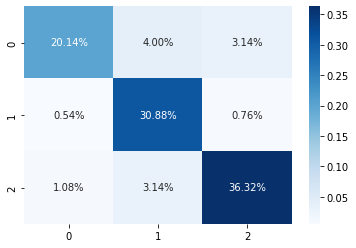

In [39]:
sb.heatmap(RFC_model[6]/np.sum(RFC_model[6]), annot=True,fmt='.2%', cmap='Blues')

#### 6.3.2 Ridge Regression
La regresión Ridge es un modelo de regresión lineal penalizado para predecir un valor numérico, sin embargo, puede ser muy eficaz cuando se aplica a la clasificación.

Quizá el parámetro más importante que hay que ajustar es la fuerza de regularización (alfa). Un buen punto de partida podrían ser valores en el rango [0,1 a 1,0]

por defecto alpha=1.0

In [40]:
#Ridge Classifier
RGC = RidgeClassifier()
RGC_params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
RGC_model = build_model(RGC,RGC_params,X_train,X_test,y_train,y_test)

Model: RidgeClassifier()
--------------------------------------------------------------------------------
Best Params:
{'alpha': 0.9}
--------------------------------------------------------------------------------
Accuracy Score: 0.8702702702702703
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84       757
     Neutral       0.85      0.89      0.87       893
    Positive       0.88      0.90      0.89      1125

    accuracy                           0.87      2775
   macro avg       0.87      0.86      0.87      2775
weighted avg       0.87      0.87      0.87      2775

--------------------------------------------------------------------------------
Confusion Matrix:
[[ 609   70   78]
 [  46  791   56]
 [  40   70 1015]]


Se observa en este caso el modelo con el mejor parámetro de alfa fue de 0.9 y los resultados fueron más homogéneos entre clases, obteniendo entre 80% y 90% tanto la precisión como la sensibilidad de todas las clases. Aunado a esto, la exactitud general del modelo fue casi tan buena como la del Random Forest.


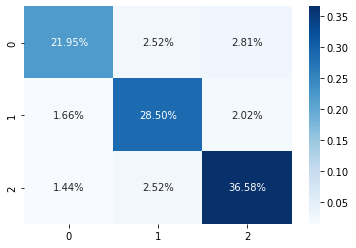

In [41]:
sb.heatmap(RGC_model[6]/np.sum(RGC_model[6]), annot=True,fmt='.2%', cmap='Blues')

#### 6.3.3 K Nearest Neighbors

El hiper parámetro más importante para KNN es el número de vecinos (n_neighbors), sin embargo, para este caso en particular, este parámetro será fijo, pues el número de vecinos siempre serán 3 (las tres categorías).

También puede ser interesante probar diferentes métricas de distancia (metric) para elegir la composición del vecindario, o probar la contribución de los miembros del vecindario mediante diferentes ponderaciones (weights).



In [42]:
#K Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors=3)
KNN_params = {'metric':['euclidean', 'manhattan', 'minkowski'],
              'weights':['uniform', 'distance']}
KNN_model = build_model(KNN,KNN_params,X_train,X_test,y_train,y_test)

Model: KNeighborsClassifier(n_neighbors=3)
--------------------------------------------------------------------------------
Best Params:
{'metric': 'manhattan', 'weights': 'distance'}
--------------------------------------------------------------------------------
Accuracy Score: 0.5881081081081081
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.39      0.55       757
     Neutral       0.44      0.99      0.61       893
    Positive       0.98      0.41      0.58      1125

    accuracy                           0.59      2775
   macro avg       0.79      0.59      0.58      2775
weighted avg       0.80      0.59      0.58      2775

--------------------------------------------------------------------------------
Confusion Matrix:
[[293 460   4]
 [  7 880   6]
 [  6 660 459]]


Este algoritmo no mostró buenos resultados, obteniendo valores muy bajos en precisión para la clase Neutral y muy bajos en sensibilidad para la clase Negativa. Dados los resultados de este modelo, queda descartado como posible solución al problema en cuestión.


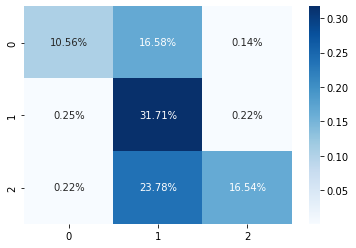

In [43]:
sb.heatmap(KNN_model[6]/np.sum(KNN_model[6]), annot=True,fmt='.2%', cmap='Blues')

#### 6.3.4 Support Vector Machines

El algoritmo SVM es muy popular, muy eficaz y ofrece un gran número de hiperparámetros para ajustar.

Quizás el primer parámetro importante es la elección del núcleo que controlará la forma en que se proyectarán las variables de entrada. Hay muchos entre los que elegir, pero los más comunes son el lineal, el polinómico y el RBF, quizás sólo el lineal y el RBF en la práctica.

Otro parámetro crítico es la penalización (C), que puede tomar un rango de valores y tiene un efecto dramático en la forma de las regiones resultantes para cada clase. Una escala logarítmica podría ser un buen punto de partida.

Por default los parámetros están establecidos como C=1.0, kernel='rbf'.

In [44]:
#Support Vector Machines
SVM = SVC()
SVM_params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
SVM_model = build_model(SVM,SVM_params,X_train,X_test,y_train,y_test)

Model: SVC()
--------------------------------------------------------------------------------
Best Params:
{'kernel': 'linear'}
--------------------------------------------------------------------------------
Accuracy Score: 0.8803603603603604
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84       757
     Neutral       0.86      0.91      0.88       893
    Positive       0.90      0.91      0.90      1125

    accuracy                           0.88      2775
   macro avg       0.88      0.87      0.88      2775
weighted avg       0.88      0.88      0.88      2775

--------------------------------------------------------------------------------
Confusion Matrix:
[[ 609   72   76]
 [  44  813   36]
 [  43   61 1021]]


Con un kernel lineal, se observa que hasta ahora el algoritmo de SVM ha obtenido la mejor exactitud a nivel general (88%), así como la mejor relación y balance de precisión y sensibilidad en todas las clases.

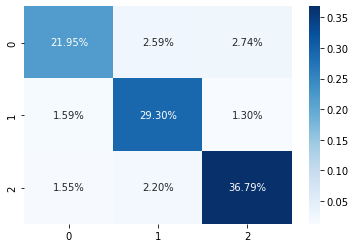

In [45]:
sb.heatmap(SVM_model[6]/np.sum(SVM_model[6]), annot=True,fmt='.2%', cmap='Blues')

Tal como las métricas anteriores, la diagonal principal de esta matriz de confusión también contiene valores muy elevados y más parecidos a los valores reales.

#### 6.3.5 Multinomial Naive Bayes

Los estimadores Naive Bayes son estimadores probabilísticos basados en el teorema de Bayes con la suposición de que existe una fuerte independencia entre las características. El teorema de Bayes nos ayuda a averiguar la probabilidad de que se produzcan sucesos basándose en un conocimiento previo de las condiciones que pueden estar relacionadas con el suceso. Los clasificadores Bayes ingenuos han funcionado bastante bien para la clasificación de documentos y las aplicaciones de filtrado de spam. Requiere una pequeña cantidad de datos de entrenamiento para establecer las probabilidades del teorema de Bayes y, por lo tanto, funciona con bastante rapidez.

Por defecto, alpha = 1.

In [46]:
#Multinomial Naive Bayes Classifier
MNB = MultinomialNB()
MNB_params = {'alpha':[.01, .1, .5, 1, 10]}
MNB_model = build_model(MNB,MNB_params,X_train,X_test,y_train,y_test)

Model: MultinomialNB()
--------------------------------------------------------------------------------
Best Params:
{'alpha': 0.1}
--------------------------------------------------------------------------------
Accuracy Score: 0.7556756756756757
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.69      0.73       757
     Neutral       0.86      0.65      0.74       893
    Positive       0.70      0.88      0.78      1125

    accuracy                           0.76      2775
   macro avg       0.78      0.74      0.75      2775
weighted avg       0.77      0.76      0.75      2775

--------------------------------------------------------------------------------
Confusion Matrix:
[[525  43 189]
 [ 81 578 234]
 [ 79  52 994]]


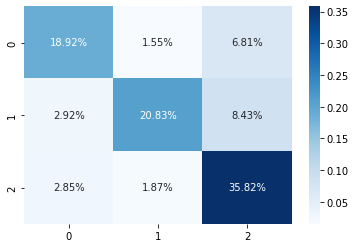

In [47]:
sb.heatmap(MNB_model[6]/np.sum(MNB_model[6]), annot=True,fmt='.2%', cmap='Blues')

La matriz de confusión también presenta poca variabilidad en los resultados, es decir, las predicciones no están tan desbalanceadas.

# 7. Comparativa de Modelos

In [48]:
resultados = pd.DataFrame({'model':['Random Forest','Ridge','SVM','KNN','MultiNB'],
                          'accuracy':[RFC_model[4],RGC_model[4],SVM_model[4],KNN_model[4],MNB_model[4]],
                           'mean_accuracy':[RFC_model[2].values[0],RGC_model[2].values[0],SVM_model[2].values[0],KNN_model[2].values[0],MNB_model[2].values[0]],
                           'std_accuracy':[RFC_model[3].values[0],RGC_model[3].values[0],SVM_model[3].values[0],KNN_model[3].values[0],MNB_model[3].values[0]],
                           'exec_time':[RFC_model[7],RGC_model[7],SVM_model[7],KNN_model[7],MNB_model[7]]})
resultados

,model,accuracy,mean_accuracy,std_accuracy,exec_time
0,Random Forest,0.873514,0.841025,0.011431,302.392820
1,Ridge,0.870270,0.846522,0.002402,3.995471
2,SVM,0.880360,0.848684,0.002063,128.070101
3,KNN,0.588108,0.560743,0.007686,53.281089
4,MultiNB,0.755676,0.768025,0.002079,0.643825


In [51]:
px.scatter(resultados,x='exec_time',y='mean_accuracy',size='std_accuracy',color='model',opacity=0.7)

___

# 8. Conclusión

El análisis de texto es una herramienta muy poderosa al momento de tener datos en crudo que aportan mucho valor. El análisis de sentimiento particularmente para redes sociales se ha vuelto muy relevante pues la cantidad inmensa de contenido que se genera ha derivado en la necesidad de realizar mayor limpieza y de categorizar o etiquetar los comentarios.

En este proyecto se observó que la técnica más efectiva para abordar el análisis de sentimiento fue la del algoritmo de VADER, por ser comentarios obtenidos de una red social.
